In [ ]:
import os
from ib_async import *
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import squareform
import dcor
import gc
from datetime import datetime, timedelta
from tqdm import tqdm
from collections import defaultdict
import itertools
from time import sleep
import csv
from scipy.optimize import minimize
from fredapi import Fred
import pandas_datareader.data as web
import math
import re
import ast


pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

In [3]:
kind = 'midpoint'
kind = 'trades'
# kind = 'indices'

if kind == 'midpoint':
    root = 'data/daily-midpoint/'
elif kind == 'trades':
    root = 'data/daily-trades/'
elif kind == 'indices':
    root = 'data/indices/'

data_path = root + 'series/'
verified_path = root + 'verified_files.txt'

In [ ]:
# Connect to ibkr
util.startLoop()

ib = IB()
ib.connect('127.0.0.1', 7497, clientId=1)

In [ ]:
def get_historical(symbol, exchange, currency, duration='40 Y', kind=None):
    contract = Stock(symbol, exchange, currency)
    if kind == 'midpoint':
        data = ib.reqHistoricalData(
            contract, 
            endDateTime='',
            durationStr=duration,
            barSizeSetting='1 day', 
            whatToShow='MIDPOINT', 
            useRTH=True,
        )
    elif kind == 'trades' or kind == 'indices':
        data = ib.reqHistoricalData(
            contract, 
            endDateTime='',
            durationStr=duration,
            barSizeSetting='1 day', 
            whatToShow='TRADES', 
            useRTH=True,
        )
    length = len(data) - 1 if data and exchange == 'SMART' else len(data)
    return data, length, exchange

def save_data(data_path, data, symbol, exchange, currency):
    if data:
        data_df = util.df(data)
        data_df['date'] = pd.to_datetime(data_df['date'])
        data_df = data_df.sort_values(by='date').reset_index(drop=True)
        data_df.to_csv(f'{data_path}{symbol}-{exchange}-{currency}.csv', index=False)
        # print(f'{symbol} saved')

In [ ]:
# Get missing historical series
if kind == 'indices':
    raise Exception('Incorrect kind for this. Needs to be trades or midpoint)')

years = ['40 Y', '20 Y', '10 Y', '5 Y', '3 Y', '2 Y', '1 Y']
# years = ['1 Y']
for duration in years:
    contracts_df = pd.read_csv('data/contract_elaborated.csv')
    contracts_df['search_exchange'] = contracts_df['search_exchange'].str.extract(r'\((.*?)\)').fillna('')
    file_list = os.listdir(data_path)
    file_list = [name.split('-')[0] for name in file_list]

    missing_symbols = contracts_df[~contracts_df['symbol'].isin(file_list)].copy()
    count = 0
    for _, row in tqdm(missing_symbols.iterrows(), total=len(missing_symbols), desc=f"Getting {duration} series"):
        symbol = row['symbol']
        search_exchange = row['search_exchange']
        suggested_exchange = row['exchange']
        primary_exchange = row['primaryExchange']
        currency = row['currency']
        
        results = []
        if search_exchange:
            results.append(get_historical(symbol, search_exchange, currency, duration=duration, kind=kind))
            if suggested_exchange != search_exchange:
                results.append(get_historical(symbol, suggested_exchange, currency, duration=duration, kind=kind))
            if primary_exchange != suggested_exchange and primary_exchange != search_exchange:
                results.append(get_historical(symbol, primary_exchange, currency, duration=duration, kind=kind))
        else:
            results.append(get_historical(symbol, suggested_exchange, currency, duration=duration, kind=kind))
            if primary_exchange != suggested_exchange:
                results.append(get_historical(symbol, primary_exchange, currency, duration=duration, kind=kind))
        results.append(get_historical(symbol, 'SMART', currency, duration=duration, kind=kind))
        results = sorted(results, key=lambda x: x[1], reverse=True)
        if results[0][1]:
            save_data(data_path, results[0][0], symbol, results[0][2], currency)
            count +=1

    print(f'{duration}: {count} scraped')

In [ ]:
# # Check scraping differences
# def get_csv_lengths(directory):
#     """Returns a dictionary mapping (symbol, exchange, currency) to their row counts."""
#     csv_lengths = {}
#     for file in os.listdir(directory):
#         if file.endswith(".csv"):
#             file_path = os.path.join(directory, file)
#             try:
#                 df = pd.read_csv(file_path)
#                 file_key = os.path.splitext(file)[0]  # Remove .csv extension
#                 parts = file_key.split('-')
#                 if len(parts) == 3:
#                     symbol, exchange, currency = parts
#                     csv_lengths[(symbol, exchange, currency)] = len(df)
#             except Exception as e:
#                 print(f"Error reading {file_path}: {e}")
#                 csv_lengths[(symbol, exchange, currency)] = None
#     return csv_lengths

# def main(dir1, dir2, dir3):
#     """Generates a DataFrame with symbol, exchange, currency, and row counts from three directories."""
#     lengths1 = get_csv_lengths(dir1)
#     lengths2 = get_csv_lengths(dir2)
#     lengths3 = get_csv_lengths(dir3)
    
#     # Collect all unique (symbol, exchange, currency) combinations
#     all_keys = set(lengths1.keys()) | set(lengths2.keys()) | set(lengths3.keys())
    
#     data = []
#     for key in sorted(all_keys):
#         symbol, exchange, currency = key
#         data.append([symbol, exchange, currency, lengths1.get(key, 'N/A'), lengths2.get(key, 'N/A'), lengths3.get(key, 'N/A')])
    
#     return pd.DataFrame(data, columns=["symbol", "exchange", "currency", dir1, dir2, dir3])

# # Example usage
# dir1 = "data/indices/series/"
# dir2 = "data/daily-midpoint/series/"
# dir3 = "data/daily-trades/series/"
# df = main(dir1, dir2, dir3)
# # df[df.duplicated(subset='symbol', keep=False)]

In [ ]:
# # Get indices
# '''
# SPY - SnP 500 -- US centric
# VTI - Vanguard Total Stock Market -- US centric
# VEU - Vanguard All-World Ex-US -- Global
# VXUS - Vanguard Total International -- Global
# BND - Vanguard Total Bond -- US
# BNDX - Vanguard Total International Bond -- Global
# '''
# indices = [Stock('SPY', 'SMART', 'USD'), Stock('VTI', 'SMART', 'USD'), Stock('VEU', 'SMART', 'USD'), Stock('VXUS', 'SMART', 'USD'), Stock('BND', 'SMART', 'USD'), Stock('BNDX', 'SMART', 'USD')]
# index_path = 'data/indices/series/'
# for contract in tqdm(indices, total=len(indices), desc=f"Getting index series"):
#     data,_,_ = get_historical(data, contract.symbol, contract.exchange, contract.currency, kind=kind)
#     save_data(index_path, data, contract.symbol, contract.exchange, contract.currency)

In [ ]:
# Update historical series
file_list = os.listdir(data_path)

for file_name in tqdm(file_list, total=len(file_list), desc=f"Updating {data_path}"):
    symbol, exchange, currency = file_name.replace('.csv', '').split('-')
    
    file_path = os.path.join(data_path, file_name)
    data_df = pd.read_csv(file_path)
    data_df['date'] = pd.to_datetime(data_df['date'])
    last_date = data_df['date'].max()
    time_missing = (datetime.now() - last_date).days
    if time_missing > 364:
        time_missing = math.ceil(time_missing / 364)
        duration = f'{time_missing} Y'
    else:
        duration = f'{time_missing} D'
    
    if time_missing:
        new_data,_,_ = get_historical(symbol, exchange, currency, duration=duration, kind=kind)
        if new_data:
            new_data_df = util.df(new_data)
            new_data_df['date'] = pd.to_datetime(new_data_df['date'])
            updated_data_df = pd.concat([new_data_df, data_df]).drop_duplicates(subset='date').sort_values(by='date').reset_index(drop=True)
            updated_data_df.to_csv(file_path, index=False)

---
### Prep indices
---

In [ ]:
# Load and prepare indices
def melt(data_df):
    value_columns = ['open', 'close']
    id_columns = [col for col in data_df.columns.to_list() if col not in value_columns]
    melted_df = data_df.melt(id_vars=id_columns, value_vars=value_columns, var_name='kind', value_name='value')
    return melted_df.sort_values(by=['date', 'kind'], ascending=[True, False]).reset_index(drop=True)

# Load indices and merge them all into one df
indices = {}
file_list = os.listdir('data/indices/series/')
for file in file_list:
    symbol = os.path.splitext(file)[0].split('-')[0]
    indices[symbol] = pd.read_csv('data/indices/series/' + file)

# Melt indices, filters, and calc pct_change. ASSUMES that indices are sorted chronologically
training_start_date = pd.to_datetime('2020-02-01')
month_ago = datetime.today() - timedelta(days=31)

day_gap = 6 # SET ACCEPTABLE DAY GAP

melted_indices, index_returns = [], {}
for symbol, df in tqdm(indices.items(), total=len(indices), desc=f'Melting and filtering {kind} indices'):
    df = melt(df)
    df['date'] = pd.to_datetime(df['date'])

    latest_date = df['date'].iloc[-1]
    earliest_date = df['date'].iloc[0]
    dates = df['date'].unique()
    date_gaps = dates[1:] - dates[:-1]
    df['symbol'] = symbol
    df['pct_change'] = df['value'].pct_change()
    index_returns[symbol] = df['pct_change'].mean()
    melted_indices.append(df)
print(f'Loaded {len(melted_indices)} out of {len(file_list)} series ({round(len(melted_indices)/len(file_list)*100, 4)}%)')

# Concatenate and pivot data
index_df = pd.concat(melted_indices, ignore_index=True)
index_df = index_df.pivot(index=['date', 'kind'], columns='symbol', values='pct_change')
index_df = index_df.sort_values(by=['date', 'kind'], ascending=[True, False]).reset_index()#.dropna()

---
### Clean historical data
---

In [3]:
# Define verified files
try:
    with open(verified_path, 'r') as f:
        lines = f.readlines()
        verified_files = [line.strip() for line in lines]
    file_list = os.listdir(data_path)
except FileNotFoundError:
    file_list = os.listdir(data_path)
    contracts_df = pd.read_csv('data/contract_elaborated.csv')

    verified_files = []
    for file_name in tqdm(file_list, total=len(file_list), desc=f"Verifying {kind} series with elaborated data"):
        symbol, exchange, currency = file_name.replace('.csv', '').split('-')
        try:
            contract_details = ib.reqContractDetails(Stock(symbol, exchange, currency))
            id = contract_details[0].secIdList[0].value

            if contracts_df[contracts_df['symbol'] == symbol]['isin'].iloc[0] == id:
                
                instrument_name = contracts_df[contracts_df['symbol'] == symbol]['longName'].iloc[0]
                instrument_name = instrument_name.replace('-', '').replace('+', '')
                for word in instrument_name.split():
                    if re.fullmatch(r'\d+X', word):
                        if int(word[:-1]) > 1:
                            continue
                        if word.startswith(('LV', 'LEV')):
                            print(f'    {instrument_name}')
                            
                verified_files.append(file_name.split('-')[0])
        except Exception as e:
            print(e)

    with open(verified_path, 'w') as f:
        for item in verified_files:
            f.write(str(item) + '\n')

In [4]:
# Load and prepare historical training data
# def melt(data_df, value_columns=None):
#     if not value_columns:
#         value_columns = ['open', 'close']
#     id_columns = [col for col in data_df.columns.to_list() if col not in value_columns]
#     melted_df = data_df.melt(id_vars=id_columns, value_vars=value_columns, var_name='kind', value_name='value')
#     return melted_df.sort_values(by=['date', 'kind'], ascending=[True, False]).reset_index(drop=True)

def clean_series(df, window=14, z=3):
    # Ensure dates and numeric types
    df['date'] = pd.to_datetime(df['date'])
    for col in ['open', 'high', 'low', 'close', 'volume', 'average', 'barCount']:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    if kind == 'trades' or 'indices':
        price_col = 'average'
    else:
        price_col = 'close'

    # Basic consistency checks
    # df['inconsistent'] = (df['low'] > df['high']) | (df[price_col] < df['low']) | (df[price_col] > df['high'])
    df['negatives'] = (df[price_col] < 0) | (df['volume'] < 0) # | (df['low'] < 0) | (df['high'] < 0)
    
    # df = df[~(df['open'] > (df['open'].median() + df['open'].std() * z))]
    # df = df[~(df[price_col] > (df[price_col].median() + df[price_col].std() * z))]
    # Outlier detection
    df['total_outlier'] = (df[price_col] > (df[price_col].median() + df[price_col].std() * z)) | (df[price_col] < (df[price_col].median() - df[price_col].std() * z)) 
    
    rolling_median = df[price_col].rolling(window=window, center=True, min_periods=1).mean()
    rolling_std = df[price_col].rolling(window=window, center=True, min_periods=1).std()
    std_threshold = z * rolling_std
    df['std_outlier'] = np.abs(df[price_col] - rolling_median) > std_threshold

    rolling_mad = df[price_col].rolling(window=window, center=True, min_periods=1).apply(lambda x: np.mean(np.abs(x - np.median(x))), raw=True)
    mad_threshold = z * rolling_mad
    df['mad_outlier'] = np.abs(df[price_col] - rolling_median) > mad_threshold
    
    rolling_iqr = df[price_col].rolling(window=window, center=True, min_periods=1).apply(lambda x: np.subtract(*np.percentile(x, [75, 25])), raw=True)
    iqr_threshold = z * rolling_iqr
    df['iqr_outlier'] = np.abs(df[price_col] - rolling_median) > iqr_threshold

    df['all'] = df['std_outlier'] & df['mad_outlier'] & df['iqr_outlier']
    
    
    return df, len(df), df['negatives'].sum(), df['inconsistent'].sum(), df['total_outlier'].sum(), df['std_outlier'].sum(), df['mad_outlier'].sum(), df['iqr_outlier'].sum(), df['all'].sum()
    return df.drop(['barCount'], axis=1), len(df), df['negatives'].sum(), df['inconsistent'].sum(), df['total_outlier'].sum(), df['std_outlier'].sum(), df['mad_outlier'].sum(), df['iqr_outlier'].sum()


    # Fill in rows with values that do not change the series' variance and ER


In [ ]:
# Load historical data and merge them all into one df
meta, check = [], {}
file_list = os.listdir(data_path)
for file in tqdm(file_list, total=len(file_list)):
    symbol = os.path.splitext(file)[0].split('-')[0]
    if symbol in verified_files:
        df = pd.read_csv(data_path + file)
        df, length, negatives, inconsistent, total_outlier, std_outlier, mad_outlier, iqr_outlier, all= clean_series(df, window=14, z=4)
        meta.append(pd.DataFrame({'symbol': [symbol], 'length': length, 'negatives': [negatives], 'inconsistent': [inconsistent], 'total_outlier': [total_outlier], 'std_outlier': [std_outlier], 'mad_outlier': [mad_outlier], 'iqr_outlier': [iqr_outlier], 'all': [all]}))
        check[symbol] = df
meta = pd.concat(meta)

In [ ]:
meta['all'] = meta['mad_outlier'] & meta['iqr_outlier']
meta

In [ ]:
test = check['PJSR']
test['all'] = test['std_outlier'] & test['mad_outlier'] & test['iqr_outlier']
y = test['average']
x = test['date']

plt.figure(figsize=(12, 6))
plt.plot(x, y, marker='.', linestyle='-', color='b', label='Sample Series')

# Adding title and labels
plt.title('Sample Series Plot')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# Display the plot
plt.show()
display(test)

---
### Prep historical data
---

In [ ]:
# # Test day gap
# dfs = {}
# for file in os.listdir(data_path):
#     symbol = os.path.splitext(file)[0].split('-')[0]
#     if symbol in verified_files:
#         dfs[symbol] = pd.read_csv(data_path + file)

# days, nums, lens, firsts = [], [], [], []
# for day in range(5,30):
#     days.append(day)

#     melted_dfs = []
#     expected_returns = {}
#     for symbol, df in tqdm(dfs.items(), total=len(dfs), desc=f'{day}'):
#         df = melt(df)
#         df['date'] = pd.to_datetime(df['date'])

#         latest_date = df['date'].iloc[-1]
#         earliest_date = df['date'].iloc[0]
#         length_required = pd.to_datetime('2020-02-01')
#         month_ago = datetime.today() - timedelta(days=30)

#         dates = df['date'].unique()
#         date_diffs = dates[1:] - dates[:-1]
        
#         if latest_date >= month_ago and earliest_date <= length_required and not (date_diffs > pd.Timedelta(days=day)).any():
#             df['symbol'] = symbol
#             df['pct_change'] = df['value'].pct_change()
#             expected_returns[symbol] = df['pct_change'].mean()
#             melted_dfs.append(df)
#     # print(f'Loaded {len(melted_dfs)} out of {len(file_list)} series ({round(len(melted_dfs)/len(file_list)*100, 4)}%)')

#     # Concatenate and pivot data
#     returns_df = pd.concat(melted_dfs, ignore_index=True)
#     returns_df = returns_df.pivot(index=['date', 'kind'], columns='symbol', values='pct_change')
#     returns_df = returns_df.sort_values(by=['date', 'kind'], ascending=[True, False]).reset_index().dropna()
#     lens.append(len(returns_df))
#     nums.append(len(returns_df.columns))
#     firsts.append(returns_df.date.iloc[0])

# gap_data_df = pd.DataFrame({
#     'day_gap': days,
#     'num_etfs': nums,
#     'period_length': lens,
#     'first_day':firsts})

# gap_data_df

In [5]:
# Load and prepare historical training data
# def melt(data_df, value_columns=None):
#     if not value_columns:
#         value_columns = ['open', 'close']
#     id_columns = [col for col in data_df.columns.to_list() if col not in value_columns]
#     melted_df = data_df.melt(id_vars=id_columns, value_vars=value_columns, var_name='kind', value_name='value')
#     return melted_df.sort_values(by=['date'], ascending=[True, False]).reset_index(drop=True)

# Load historical data and merge them all into one df
dfs = {}
file_list = os.listdir(data_path)
for file in file_list:
    symbol = os.path.splitext(file)[0].split('-')[0]
    if symbol in verified_files:
        dfs[symbol] = pd.read_csv(data_path + file)


# Melt dfs, filters, and calc pct_change. ASSUMES that dfs are sorted chronologically
training_start_date = pd.to_datetime('2020-02-01')
month_ago = datetime.today() - timedelta(days=31)

day_gap = 6 # SET ACCEPTABLE DAY GAP

melted_dfs, expected_returns = [], {}
for symbol, df in tqdm(dfs.items(), total=len(dfs), desc=f'Filtering {kind} dfs'):
    df['date'] = pd.to_datetime(df['date'])

    latest_date = df['date'].iloc[-1]
    earliest_date = df['date'].iloc[0]
    dates = df['date'].unique()
    date_gaps = dates[1:] - dates[:-1]
    
    if (kind == 'indices') or (latest_date >= month_ago and earliest_date <= training_start_date and (date_gaps <= pd.Timedelta(days=day_gap)).all()):
        df['symbol'] = symbol
        df['pct_change'] = df['average'].pct_change()
        expected_returns[symbol] = df['pct_change'].mean()
        melted_dfs.append(df)
print(f'Loaded {len(melted_dfs)} out of {len(file_list)} series ({round(len(melted_dfs)/len(file_list)*100, 4)}%)')

# Concatenate and pivot data
returns_df = pd.concat(melted_dfs, ignore_index=True)
returns_df = returns_df.pivot(index=['date'], columns='symbol', values='pct_change')
returns_df = returns_df.sort_values(by=['date'], ascending=[True]).reset_index()

# Define training boundaries
training_cutoff_date = datetime.today() - timedelta(days=365)
training_df = returns_df[returns_df['date'] <= training_cutoff_date]
training_matrix = training_df.drop(['date'], axis=1).dropna().copy()

Filtering trades dfs: 100%|██████████| 2878/2878 [00:01<00:00, 1834.28it/s]


Loaded 717 out of 2881 series (24.8872%)


In [6]:
# Calculate risk-free-rate for training window
treasury_rate = web.DataReader('DGS10', 'fred', training_cutoff_date-timedelta(days=365), training_cutoff_date)
nominal_rf_rate = treasury_rate.mean() / 100

fred = Fred(api_key='30ae0e4e7713662116edf836cec71562')
cpi_data = fred.get_series('CPIAUCSL', training_cutoff_date-timedelta(days=365), training_cutoff_date) # CPI
inflation_rate = (cpi_data.iloc[-1] - cpi_data.iloc[0]) / cpi_data.iloc[0]

real_rf_rate = (1 + nominal_rf_rate) / (1 + inflation_rate) - 1

In [19]:
# Calculate corr and cov for historical training data
training_array = training_matrix.values # Convert training matrix to numpy array
symbol_list = training_matrix.columns.tolist()
num_symbols = len(symbol_list)
corr_matrix = np.zeros((num_symbols, num_symbols)) # Pre-allocate numpy array for correlation
cov_matrix = np.zeros((num_symbols, num_symbols))  # Pre-allocate numpy array for covariance

for i, sym_i in tqdm(enumerate(symbol_list), total=num_symbols, desc=f"Calculating distance stats sqr"):
    for j, sym_j in enumerate(symbol_list):
        if i <= j:  # Compute only for upper triangle (including diagonal)
            stats = dcor.distance_stats(training_array[:, i], training_array[:, j])
            corr_value = stats.correlation_xy
            cov_value = stats.covariance_xy

            corr_matrix[i, j] = corr_value
            corr_matrix[j, i] = corr_value  # Fill symmetric value

            cov_matrix[i, j] = cov_value
            cov_matrix[j, i] = cov_value  # Fill symmetric value

corr_df = pd.DataFrame(corr_matrix, index=symbol_list, columns=symbol_list) # Convert numpy array back to df for output
cov_df = pd.DataFrame(cov_matrix, index=symbol_list, columns=symbol_list)   # Convert numpy array back to df for output

corr_df.to_csv(f'{root}corr_df.csv', index=False)
cov_df.to_csv(f'{root}cov_df.csv', index=False)

Calculating distance stats sqr: 100%|██████████| 717/717 [01:36<00:00,  7.42it/s]


---
### Compute etf combinations based on optimal k_clusters
---

In [4]:
# Load corr and cov
corr_df = pd.read_csv(f'{root}corr_df.csv')
cov_df = pd.read_csv(f'{root}cov_df.csv')
symbol_list = corr_df.columns

symbol2index = dict(zip(corr_df.columns, corr_df.index))
index2symbol = dict(zip(corr_df.index, corr_df.columns))
corr_df.rename(columns=symbol2index, inplace=True)
cov_df.rename(columns=symbol2index, inplace=True)

distance_matrix = (1 - corr_df).to_numpy()
np.fill_diagonal(distance_matrix, 0)

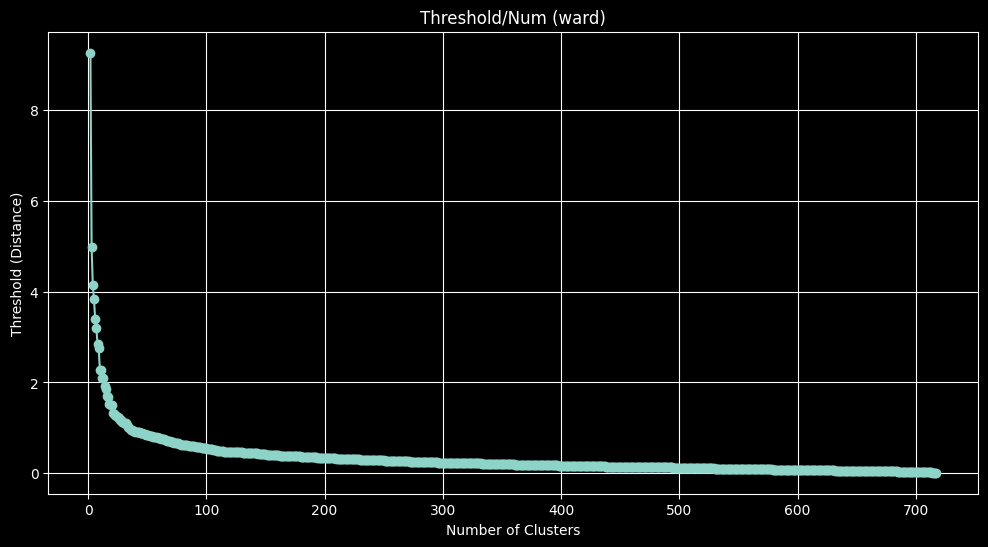

In [21]:
# Thresholds / cluster_num graphs
methods = ['single', 'ward', 'average', 'complete', 'weighted', 'centroid', 'median']
methods = ['ward']
for method in methods:
    linked = sch.linkage(squareform(distance_matrix), method=method)
    
    num_clusters = range(len(corr_df), 1, -1)
    thresholds = linked[:, 2]

    # inertias = []
    # for n_clusters in num_clusters:
    #     cluster_labels = fcluster(linked, t=n_clusters, criterion='maxclust')
    #     inertia = 0
    #     for cluster in np.unique(cluster_labels):
    #         members = distance_matrix.values[cluster_labels == cluster]
    #         centroid = members.mean(axis=0)  # Cluster centroid
    #         inertia += np.sum((members - centroid) ** 2)
    #     inertias.append(inertia)

    # plt.figure(figsize=(12, 6))
    # plt.plot(num_clusters, inertias, marker='o', label=f"Method {method}")
    # plt.title(f"Inertia/Num ({method})")
    # plt.xlabel('Number of Clusters')
    # plt.ylabel('Inertia (Sum of Squared Distances)')
    # plt.grid(True)
    # plt.legend()
    # plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(num_clusters, thresholds, marker='o')
    plt.title(f"Threshold/Num ({method})")
    plt.xlabel('Number of Clusters')
    plt.ylabel('Threshold (Distance)')
    plt.grid(True)
    plt.show()


/Users/alex/Documents/pystocks/venv/lib/python3.12/site-packages/scipy/cluster/hierarchy.py:796: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/Users/alex/Documents/pystocks/venv/lib/python3.12/site-packages/scipy/cluster/hierarchy.py:796: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/Users/alex/Documents/pystocks/venv/lib/python3.12/site-packages/scipy/cluster/hierarchy.py:796: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/Users/alex/Documents/pystocks/venv/lib/python3.12/site-packages/scipy/cluster/hierarchy.py:796: ClusterWarning: The symmetric non-negative hollow observation matrix looks 

,k,score,counts,combitions
0,2,0.333205,"{0: 473, 1: 244}",115412
3,5,0.152106,"{0: 258, 1: 94, 2: 215, 3: 93, 4: 57}",27640368180
2,4,0.140289,"{0: 150, 1: 258, 2: 215, 3: 94}",782127000
5,7,0.136407,"{0: 94, 1: 93, 2: 135, 3: 153, 4: 57, 5: 123, 6: 62}",78488794358820
4,6,0.111155,"{0: 215, 1: 94, 2: 135, 3: 93, 4: 57, 5: 123}",1778946952050
1,3,0.110956,"{0: 244, 1: 258, 2: 215}",13534680
6,8,0.104411,"{0: 93, 1: 153, 2: 135, 3: 70, 4: 57, 5: 123, 6: 62, 7: 24}",1402778452370400


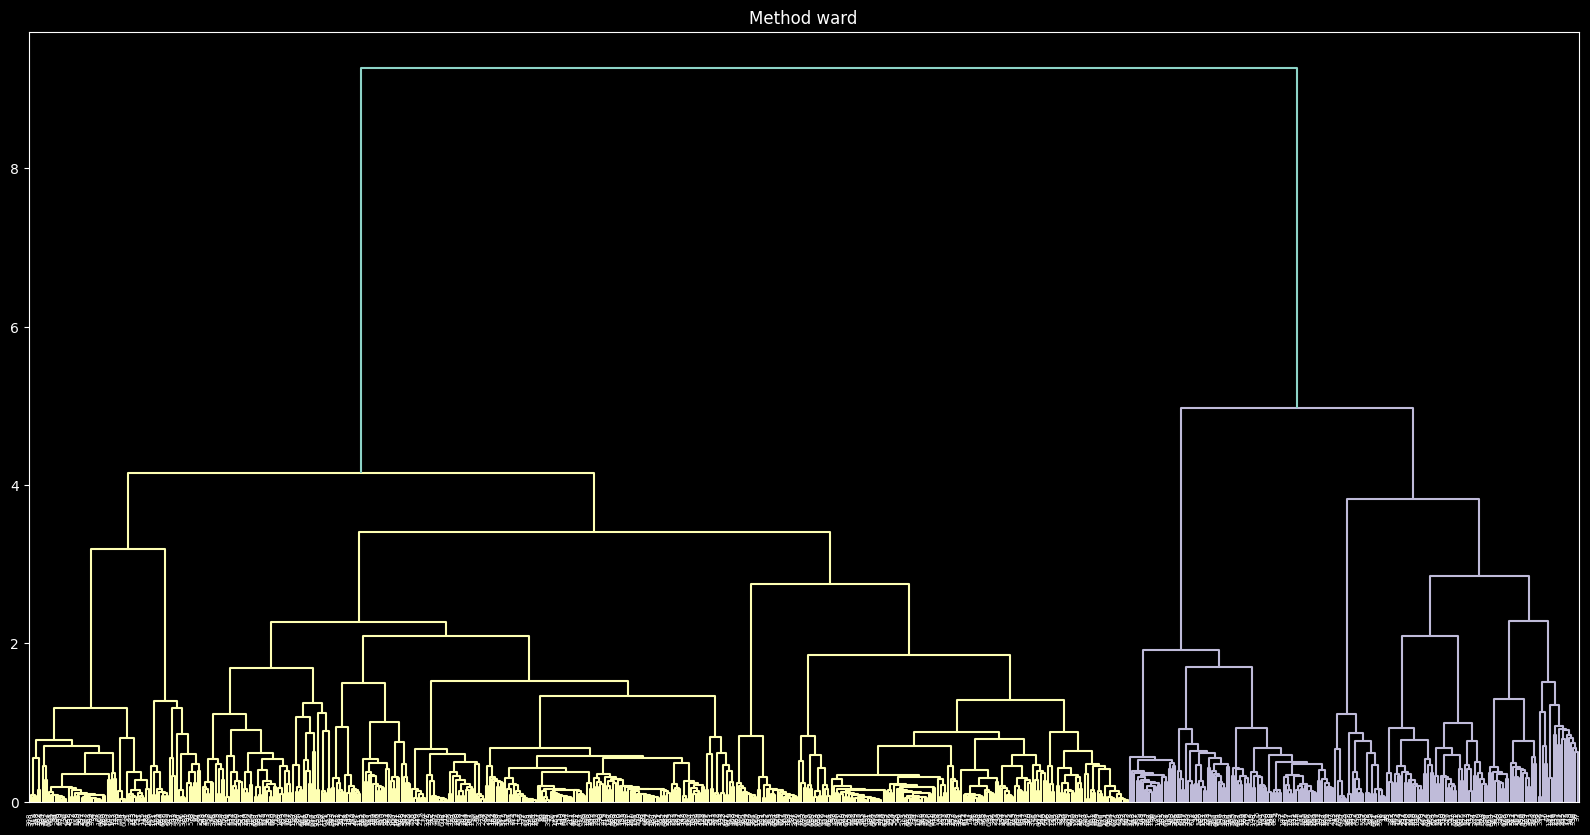

In [5]:
# Silhouettes and dendrograms
def product(row):
    product = 1
    for value in row.values():
        product *= value
    return product

ks = []
scores = []
counts = []
for k in range(2, min(len(distance_matrix), 9)):
    clusters = AgglomerativeClustering(n_clusters=k, linkage='ward').fit_predict(distance_matrix)
    score = silhouette_score(distance_matrix, clusters, metric='precomputed')
    ks.append(k)
    scores.append(score)
    unique_clusters, label_counts = np.unique(clusters, return_counts=True)
    label_counts_dict = dict(zip(unique_clusters, label_counts))
    counts.append(label_counts_dict)

silhouettes = pd.DataFrame({
    'k': ks,
    'score': scores,
    'counts': counts
})
silhouettes['combitions'] = silhouettes['counts'].apply(product)
silhouettes = silhouettes.sort_values(by='score', ascending=False)
best_k = silhouettes.k.iloc[0]

# best_k = 3

display(silhouettes)
methods = ['single', 'ward', 'average', 'complete', 'weighted', 'centroid', 'median']
methods = ['ward']
for method in methods:
    # Now compute the linkage using a condensed distance matrix
    linked = sch.linkage(squareform(distance_matrix), method=method)
    plt.figure(figsize=(20, 10))
    sch.dendrogram(linked, labels=corr_df.index, leaf_rotation=90)
    plt.title(f"Method {method}")
    plt.show()

In [19]:
# Check cluster data
def evaluate_literal(val):
    try:
        return ast.literal_eval(val)
    except (ValueError, SyntaxError):
        return val

contracts_df = pd.read_csv('data/contract_elaborated.csv')

columns_to_explode = ['profile', 'style', 'lipper', 'fundamentals', 'holding_types', 'dividends', 'industries', 'countries', 'currencies', 'debtors', 'maturity', 'debt_type']
for col in columns_to_explode:
    contracts_df[col] = contracts_df[col].fillna('[]')

contracts_df = contracts_df.applymap(evaluate_literal)

# columns_to_explode = ['profile', 'style', 'lipper', 'dividends', 'debtors', 'maturity', 'debt_type']
# columns_to_explode = ['profile']

# for col in tqdm(columns_to_explode, total=len(columns_to_explode)):
#     contracts_df = contracts_df.explode(col)
#     contracts_df.reset_index(drop=True, inplace=True)
#     display(contracts_df)
    
#     tuple_df = pd.DataFrame(contracts_df[col].tolist(), index=contracts_df.index)
#     tuple_df.columns = [f"{col}_{label}" for label in tuple_df.iloc[0]]
    
#     contracts_df.drop(columns=[col], inplace=True)
#     contracts_df = pd.concat([contracts_df, tuple_df], axis=1)


# clusters = AgglomerativeClustering(n_clusters=best_k, linkage='ward').fit_predict(distance_matrix)
# cluster_df = pd.DataFrame({
#     'symbol': symbol_list,
#     'cluster': clusters
# })

# contracts_df = contracts_df.merge(cluster_df, on='symbol', how='left')
# contracts_df = contracts_df[~contracts_df['cluster'].isna()]
# contracts_df

/var/folders/lc/8ly6wjg14dx9xm7yjml4w3z80000gn/T/ipykernel_70032/377940840.py:14: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  contracts_df = contracts_df.applymap(evaluate_literal)


In [29]:
import pandas as pd
import numpy as np
import ast

def safe_literal_eval(val):
    if isinstance(val, str):
        try:
            return ast.literal_eval(val)
        except (ValueError, SyntaxError):
            return np.nan
    return val

contracts_df = pd.read_csv('data/contract_elaborated.csv')

columns_to_explode = ['profile', 'style', 'lipper', 'fundamentals', 'holding_types', 'dividends', 'industries', 'countries', 'currencies', 'debtors', 'maturity', 'debt_type']

for col in columns_to_explode:
    contracts_df[col] = contracts_df[col].fillna('[]')
    contracts_df[col] = contracts_df[col].apply(safe_literal_eval)

contracts_df = contracts_df.explode('holding_types')
contracts_df[['holding_type', 'percentage']] = pd.DataFrame(contracts_df['holding_types'].tolist(), index=contracts_df.index)
contracts_df = contracts_df.pivot_table(index=contracts_df.index, columns='holding_type', values='percentage', aggfunc='first')
contracts_df = pd.concat([contracts_df, contracts_df.groupby(level=0).first()], axis=1)
contracts_df = contracts_df.loc[:,~contracts_df.columns.duplicated()]
contracts_df

holding_type,1Equity,1FixedIncome,Cash,Equity,FixedIncome,Other,■Cash,■Equity,■FixedIncome
0,NaN,NaN,0.12%,99.88%,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,100%,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,0.93%,NaN,99.07%,NaN,NaN,NaN,NaN
6,NaN,NaN,95.17%,NaN,4.83%,NaN,NaN,NaN,NaN
7,NaN,NaN,0.44%,NaN,100.79%,-1.23%,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
3049,NaN,NaN,0.12%,99.88%,NaN,NaN,NaN,NaN,NaN
3050,NaN,NaN,NaN,NaN,NaN,100%,NaN,NaN,NaN
3051,NaN,NaN,NaN,100%,NaN,NaN,NaN,NaN,NaN
3053,NaN,NaN,0.24%,99.76%,NaN,NaN,NaN,NaN,NaN


---
### Calculate Minimum Variance Portfolios
---

In [ ]:
# Portfolio Optimization Functions
def portfolio_variance(weights, cov_matrix):
    return weights.T @ cov_matrix @ weights

def portfolio_expected_return(weights, expected_returns_arr):
    return weights @ expected_returns_arr

def minimize_portfolio_variance(cov_matrix, expected_returns_arr):
    num_assets = len(cov_matrix)
    initial_weights = np.array([1/num_assets] * num_assets)
    bounds = tuple((0, 1) for _ in range(num_assets))
    constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})

    optimization_result = minimize(portfolio_variance,
                                    initial_weights,
                                    args=(cov_matrix,),
                                    method='SLSQP',
                                    bounds=bounds,
                                    constraints=constraints)

    if optimization_result.success:
        optimized_weights = optimization_result.x
        port_variance = optimization_result.fun
        port_std = np.sqrt(port_variance)
        port_er = portfolio_expected_return(optimized_weights, expected_returns_arr)

        return (optimized_weights, port_std, port_er)
    else:
        return (np.nan, np.nan, np.nan)

In [23]:
# Portfolio Optimization Functions
def compute_distance_sum(combination, distance_matrix):
    distance_sum = 0
    for i_idx, j_idx in itertools.combinations(combination, 2):
        distance_sum += distance_matrix[i_idx, j_idx]
    return distance_sum

def portfolio_variance(weights, cov_matrix):
    return weights.T @ cov_matrix @ weights

def portfolio_expected_return(weights, expected_returns_arr):
    return weights @ expected_returns_arr

def sharpe_ratio(weights, expected_returns_arr, cov_matrix, risk_free_rate):
    port_er = portfolio_expected_return(weights, expected_returns_arr)
    port_variance = portfolio_variance(weights, cov_matrix)
    port_std = np.sqrt(port_variance)
    return (port_er - risk_free_rate) / port_std

def negative_sharpe_ratio(weights, expected_returns_arr, cov_matrix, risk_free_rate):
    return -sharpe_ratio(weights, expected_returns_arr, cov_matrix, risk_free_rate)

def find_tangency_portfolio(cov_matrix, expected_returns_arr, risk_free_rate):
    num_assets = len(cov_matrix)
    initial_weights = np.array([1/num_assets] * num_assets)
    bounds = tuple((0, 1) for _ in range(num_assets))
    constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})

    optimization_result = minimize(negative_sharpe_ratio,
                                    initial_weights,
                                    args=(expected_returns_arr, cov_matrix, risk_free_rate),
                                    method='SLSQP',
                                    bounds=bounds,
                                    constraints=constraints)

    if optimization_result.success:
        optimized_weights = optimization_result.x
        variance = portfolio_variance(optimized_weights, cov_matrix)
        std = np.sqrt(variance)
        er = portfolio_expected_return(optimized_weights, expected_returns_arr)
        sharpe_ratio = -(optimization_result.fun)

        return (optimized_weights, std, er, sharpe_ratio)
    else:
        return (np.nan, np.nan, np.nan, np.nan)
    
def sort_top_combinations(array, sort_index):
    valid_rows = ~np.isnan(array[:, sort_index])
    valid_array = array[valid_rows]
    if valid_array.size > 0:
        sort_values = valid_array[:, sort_index]
        sort_indices = np.argsort(sort_values)[::-1]
        array[valid_rows] = valid_array[sort_indices]
    return array

In [ ]:
num_symbols = len(corr_df.index)
num_metrics = best_k*2 + 4
num_combinations = math.comb(num_symbols, best_k)
combination_array = np.empty((num_combinations, num_metrics), dtype='float32')

# Calculate distance sums and populate the NumPy array
for i, combination in tqdm(enumerate(itertools.combinations(range(0,num_symbols), best_k)), total=num_combinations, desc="Calculating distance sums"):
    combination_array[i, :best_k] = combination
    combination_cov_df = cov_df.loc[combination, combination]
    combination_expected_returns = np.array([expected_returns[index2symbol[index]] for index in combination])

    index_indicator = best_k + best_k + 3
    combination_array[i, best_k: index_indicator] = find_tangency_portfolio(combination_cov_df, combination_expected_returns, real_rf_rate)
    combination_array[i, index_indicator: index_indicator + 1] = compute_distance_sum(combination, distance_matrix)

    # population growth rate



# TODO - not to be sorted by best_k
sorted_indices = np.argsort(combination_array[:, best_k], kind='mergesort')[::-1]
combination_array = combination_array[sorted_indices]
del sorted_indices
combination_array, len(combination_array)

In [ ]:
num_symbols = len(corr_df.index)
num_metrics = best_k*2 + 4
num_combinations_possible = math.comb(num_symbols, best_k)

top_n = 5000 # Define how many top combinations to keep

top_combinations_array = np.empty((top_n, num_metrics), dtype='float32')
top_combinations_array[:] = np.nan
rows_filled = 0


for combination_tuple in tqdm(itertools.combinations(range(0,num_symbols), best_k), total=num_combinations_possible, desc="Calculating Tangency Portfolios"):
    combination_cov_df = cov_df.loc[combination_tuple, combination_tuple]
    combination_expected_returns = np.array([expected_returns[index2symbol[index]] for index in combination_tuple])
    weights, std, er, sharpe = find_tangency_portfolio(combination_cov_df, combination_expected_returns, real_rf_rate)
    rating = sharpe * compute_distance_sum(combination_tuple, distance_matrix)

    if rows_filled < top_n:
        top_combinations_array[rows_filled, :best_k] = combination_tuple
        top_combinations_array[rows_filled, best_k:best_k*2] = weights
        top_combinations_array[rows_filled, best_k*2: num_metrics] = [std, er, sharpe, rating]
        rows_filled += 1
        if rows_filled == top_n:
            top_combinations_array = sort_top_combinations(top_combinations_array, -1)

    else:
        if rating > top_combinations_array[-1, -1]:
            top_combinations_array[rows_filled-1, :best_k] = combination_tuple
            top_combinations_array[rows_filled-1, best_k:best_k*2] = weights
            top_combinations_array[rows_filled-1, best_k*2: num_metrics] = [std, er, sharpe, rating]
            top_combinations_array = sort_top_combinations(top_combinations_array, -1)


In [ ]:
# Remove NaN rows before further processing
top_combinations_array_cleaned = top_combinations_array[~np.isnan(top_combinations_array[:, best_k])]

print("Top", top_n, "Combinations by Sharpe Ratio:")
for row in top_combinations_array_cleaned:
    combination_indices = row[:best_k].astype(int)
    asset_symbols = [index2symbol[index] for index in combination_indices]
    # asset_symbols = [index for index in combination_indices]
    weights, std, er, sharpe, rating = row[best_k:best_k+best_k], row[best_k+best_k], row[best_k+best_k+1], row[best_k+best_k+2], row[-1]
    print(f"Assets: {asset_symbols}, Weights: {weights}, Std Dev: {std:.4f}, Expected Return: {er:.4f}, Sharpe Ratio: {sharpe:.4f}, Rating: {rating:.4f}")

# old

In [ ]:
def generate_weights(best_k, step=0.05):
    weights_list = []
    def recurse_weights(current_weights, remaining_weight, current_step):
        if len(current_weights) == best_k - 1:
            current_weights.append(remaining_weight)
            if remaining_weight >= 0:
                weights_list.append(current_weights)
            return
        for w in np.arange(0, remaining_weight + step, step):
            recurse_weights(current_weights + [w], remaining_weight - w, step)
    recurse_weights([], 1, step)
    return np.array(weights_list)


sampled_symbols = sampled_etfs['symbol'].tolist()
sample_ER = pd.DataFrame({'symbol': sampled_symbols, 'er': [expected_returns[s] for s in sampled_symbols]})
cov_matrix = returns_df[sampled_symbols].dropna().cov()#.values

weights_array = generate_weights(len(sampled_symbols))

# Now calculate portfolio ER and STD for each weight permutation
portfolio_variances = np.array([np.dot(w.T, np.dot(cov_matrix, w)) for w in weights_array])
portfolio_std = np.sqrt(portfolio_variances)
portfolio_er = weights_array.dot(sample_ER['er'])

# Create a dictionary for frontier_df
data = {f'w{i+1}': weights_array[:, i] for i in range(weights_array.shape[1])}
data['portfolio_er'] = portfolio_er
data['portfolio_std'] = portfolio_std
frontier_df = pd.DataFrame(data)

# Find efficient portfolios 
frontier_df = frontier_df.sort_values('portfolio_std')#.reset_index(drop=True)
extreme_portfolios = frontier_df.loc[(frontier_df == 1).any(axis=1)]

efficient_portfolios = pd.DataFrame(columns=frontier_df.columns)
current_max_ER = -np.inf
for idx, row in frontier_df.iterrows():
    if row['portfolio_er'] > current_max_ER:
        efficient_portfolios = pd.concat([efficient_portfolios, row.to_frame().T], ignore_index=True)
        current_max_ER = row['portfolio_er']

In [ ]:
# Fit a second-degree polynomial to the efficient frontier
coeffs = np.polyfit(efficient_portfolios['portfolio_er'], efficient_portfolios['portfolio_std'], 2)
poly_func = np.poly1d(coeffs)

x_vals = np.linspace(efficient_portfolios['portfolio_er'].min(), efficient_portfolios['portfolio_er'].max(), 100)
y_vals = poly_func(x_vals)

plt.scatter(frontier_df['portfolio_std'], frontier_df['portfolio_er'], alpha=0.1, label='All Portfolios')
plt.plot(efficient_portfolios['portfolio_std'], efficient_portfolios['portfolio_er'], 'ro', label='Efficient Frontier')
plt.plot(extreme_portfolios['portfolio_std'], extreme_portfolios['portfolio_er'], 'yo', label='Extreme Portfolios')
plt.plot(y_vals, x_vals, 'b-', label='Fitted Curve')
plt.xlabel('Portfolio Standard Deviation')
plt.ylabel('Portfolio Expected Return')
plt.legend()
plt.show()
